# Preparation

## Requirment

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchaudio
from torchaudio import transforms
import math, copy, time, random, os
import numpy as np
import scipy.io as sio
import scipy.sparse as sp
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from warmup_scheduler import GradualWarmupScheduler
from einops import rearrange
from tqdm import tqdm
import shutil

## Config

In [2]:
class Config():
    # dataloading essential
    root = '/home/test/Desktop/python/EEG_data/AAD_dataset/AAD_DTU/Processed/Dataset'
    file_name = 'S18_Dataset_1s.npz'
    sample_rate = 16000
    # encoder dim
    EEG_encoder_dim = 256
    Audio_encoder_dim = 256
    # projector dim
    Embedding_dim = 256
    Projector_dim = 128
    # EEG
    num_channels = 64
    # Audio
    clean_audio_size = 80
    noisy_audio_size = 80
    # Train
    Temperature = 0.1
    batch_size = 8
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    weight_decay = 1e-3
    EEG_encoder_lr = 2e-3
    Audio_encoder_lr = 1e-4
    head_lr = 1e-4
#     proj_lr = 2e-5
    patience = 2
    factor = 0.8
    epochs = 60
    dropout = 0.1

## Prepare Dataset

In [3]:
class EEGDataset(Dataset):
    def __init__(self, root, file_name, sample_rate=128, mode='none'):
        self.file_path = os.path.join(root, file_name)
        self.data = np.load(self.file_path, allow_pickle=True)

        self.eeg_data = self.data['eeg_slices']
        self.audioA_data = self.data['wavA_slices']
        self.audioB_data = self.data['wavB_slices']
        self.event_data = self.data['event_slices']
        self.mode = mode
        
        self.noisy_data = np.concatenate((self.audioA_data, self.audioB_data), axis=1)

    def __len__(self):
        return len(self.eeg_data)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        eeg = self.eeg_data[idx].astype(np.float32)[:64,:]
        eeg = torch.Tensor(eeg)
        eeg_min,_ = torch.min(eeg, dim=1, keepdim=True)
        eeg_max,_ = torch.max(eeg, dim=1, keepdim=True)
        eeg = (eeg-eeg_min)/(eeg_max-eeg_min)
        
        noisy = self.noisy_data[idx].astype(np.float32)

        event_np = self.event_data[idx]
        event_values = []
        for item in event_np:
            event_values.append(item[0][0][0][0])
        values_array = np.array(event_values, dtype=np.uint8)
        event = torch.tensor(values_array)
        event = event-1

        clean_audio_data = (self.audioA_data[idx] if event[0] == 0 else self.audioB_data[idx]).astype(np.float32)
        
        clean = torch.Tensor(clean_audio_data)
        wavA = torch.Tensor(self.audioA_data[idx].astype(np.float32))
        wavB = torch.Tensor(self.audioB_data[idx].astype(np.float32))
               
        return eeg, clean, wavA, wavB, event

## Utils

In [4]:
def print_size(net, keyword=None):
    """
    Print the number of parameters of a network
    """

    if net is not None and isinstance(net, torch.nn.Module):
        module_parameters = filter(lambda p: p.requires_grad, net.parameters())
        params = sum([np.prod(p.size()) for p in module_parameters])
        
        print("{} Parameters: {:.6f}M".format(
            net.__class__.__name__, params / 1e6), flush=True, end="; ")
        
        if keyword is not None:
            keyword_parameters = [p for name, p in net.named_parameters() if p.requires_grad and keyword in name]
            params = sum([np.prod(p.size()) for p in keyword_parameters])
            print("{} Parameters: {:.6f}M".format(
                keyword, params / 1e6), flush=True, end="; ")
        
        print(" ")

In [5]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [6]:
def pre_evaluate(dataloader, model):
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for eeg, audio, wavA, wavB, event in dataloader:
            eeg, audio = eeg.to(Config.device), audio.to(Config.device)
            wavA = wavA.to(Config.device)
            wavB = wavB.to(Config.device)
            event = event.to(Config.device)
            event = event.squeeze()
#             print(eeg.shape, audio.shape, wavA.shape, wavB.shape)
            _, pred = model(eeg, audio, wavA, wavB)
            # print(pred)
            _, predicted = torch.max(pred, 1)
            # print(predicted)
            correct += (predicted == event).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return accuracy

# Modle

## SincNet

In [7]:
class SincConv_fast(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, mode, low_hz = 1, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=1, min_band_hz=4):
        super(SincConv_fast,self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = low_hz
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        if mode =='eeg':
            hz = np.linspace(low_hz, high_hz, self.out_channels + 1)
            
        if mode =='audio':
            mel = np.linspace(self.to_mel(low_hz),
                              self.to_mel(high_hz),
                              self.out_channels + 1)
            hz = self.to_hz(mel)

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # Hamming window
        # computing only half of the window
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) 
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);

        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        # Due to symmetry, I only need half of the time axes
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate 

    def forward(self, waveforms):
        self.n_ = self.n_.to(waveforms.device)
        self.window_ = self.window_.to(waveforms.device)
        low = self.min_low_hz  + torch.abs(self.low_hz_)
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(high-low)[:,0]
        
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). 
        # I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)
        band_pass = band_pass / (2*band[:,None])

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.kernel_size // 2, dilation=self.dilation,
                         bias=None, groups=1) 

## EEGEncoder

In [8]:
class DepthConv1d(nn.Module):
    def __init__(self, input_channel=1, hidden_channel=2,output_channel = 1, kernel=3, padding=1, dilation=1):
        super(DepthConv1d, self).__init__()

        self.conv1d = nn.Conv1d(input_channel, hidden_channel, 1)
        self.padding = padding
        self.dconv1d = nn.Conv1d(hidden_channel, hidden_channel, kernel, dilation=dilation,
          groups=hidden_channel,
          padding=self.padding)

        self.nonlinearity1 = nn.PReLU()
        self.nonlinearity2 = nn.PReLU()

        self.reg1 = nn.GroupNorm(1, hidden_channel, eps=1e-08)
        self.reg2 = nn.GroupNorm(1, hidden_channel, eps=1e-08)
        self.skip_out = nn.Conv1d(hidden_channel, output_channel, 1)

    def forward(self, input):
        output = self.reg1(self.nonlinearity1(self.conv1d(input)))
        output = self.reg2(self.nonlinearity2(self.dconv1d(output)))
        skip = self.skip_out(output)
        return skip

In [9]:
class EEGEncoder(nn.Module):
    def __init__(self, input_channel=64,hidden_channel = 8,output_channel = 1, sample_rate=128):
        super(EEGEncoder, self).__init__()

        self.sinc_conv = SincConv_fast(out_channels=hidden_channel,mode ='eeg', low_hz = 1, kernel_size=31,
                                       sample_rate=sample_rate,min_low_hz=1, min_band_hz=4)
        
        self.depth_conv = DepthConv1d(input_channel=input_channel,output_channel = output_channel,
                                      hidden_channel=32, kernel=3, padding=1, dilation=1)

        self.fc = nn.Sequential(
            nn.Linear(hidden_channel*sample_rate, 256)  # 根据最终特征图大小调整
        )
        self.hidden_channel = hidden_channel
        self.sample_rate = sample_rate
        
    def forward(self, x):
        batch_size, input_channel, num_samples = x.size()

        # Apply SincConv to each channel independently
        sinc_out = []
        for i in range(input_channel):
            channel_data = x[:, i:i+1, :]  # Select single channel
            sinc_out.append(self.sinc_conv(channel_data))

        sinc_out = torch.stack(sinc_out, dim=1)  # Shape: [batch_size, input_channel, out_channels, output_length]
        sinc_out = sinc_out.view(batch_size, 64, self.hidden_channel*self.sample_rate)  # Reshape to [batch_size, 1, out_channels, length]
        out = self.depth_conv(sinc_out)
        out_fc = self.fc(out).squeeze()
        return out_fc# sinc_out, 

In [10]:
# # example of use EEGEncoder
# eeg_net = EEGEncoder(input_channel=64,hidden_channel = 60)  # 假设有2个类别
# input_data = torch.randn(10, 64, 128)  # 模拟输入数据
# output = eeg_net(input_data)
# print("Output shape:", output.shape)
# print_size(eeg_net)

## AudioEncoder

In [11]:
class AudioEncoder(nn.Module):
    def __init__(self, input_channel=1,out_channels=160,low_hz=30, sample_rate=16000):
        super(AudioEncoder, self).__init__()
        self.sinc_conv = SincConv_fast(out_channels=out_channels,mode ='eeg',low_hz = low_hz, kernel_size=101,
                                       sample_rate=sample_rate,min_low_hz=50, min_band_hz=50)

        self.depth_conv = DepthConv1d(input_channel=out_channels,output_channel = input_channel,
                                      hidden_channel=32, kernel=3, padding=1, dilation=1)
        
        # Use fewer convolutional layers with larger strides to reduce dimensionality
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=4, padding=1),  # torch.Size([10, 64, 4000])
            nn.PReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=4, padding=1),  # torch.Size([10, 128, 1000])
            nn.PReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=4, padding=1),  # torch.Size([10, 256, 500])
            nn.PReLU(),
            nn.AdaptiveAvgPool1d(1)  # Global average pooling  torch.Size([10, 256])
        )

    def forward(self, input):
#         print("AudioEncoder input shape:", input.shape) 
        sinc_out = self.sinc_conv(input)
        out = self.depth_conv(sinc_out)
        out = self.conv(out).squeeze(-1)  # Squeeze last dimension to get shape [batch_size, 256]
        return out

In [12]:
# # example of use AudioEncoder
# batch_size = 10
# input_length = 16000  # 一秒钟的音频数据长度
# input_channel = 1

# input_data = torch.randn(batch_size, input_channel, input_length)
# Audiomodel = AudioEncoder(input_channel=input_channel, out_channels=160, sample_rate=16000)
# output = Audiomodel(input_data)

# print(output.shape)  # torch.Size([10, 256])
# print_size(Audiomodel)

## Projector

In [13]:
class Projector(nn.Module):
    def __init__(
        self,
        embedding_dim=Config.Embedding_dim,
        projection_dim=Config.Projector_dim,
        dropout=Config.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        # (B,128)
        return x

## Contrastive Learning

In [14]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()
    
class CLIPModel(nn.Module):
    def __init__(
            self,
            temperature=Config.Temperature,
            EEG_Embedding=Config.Embedding_dim,
            Audio_Embedding=Config.Embedding_dim,
    ):
        super().__init__()

        self.eeg_encoder = EEGEncoder(input_channel=64,hidden_channel = 60)
        self.audio_encoder = AudioEncoder(out_channels=320,low_hz=100)
        self.eeg_projector = Projector(EEG_Embedding)
        self.audio_projector = Projector(Audio_Embedding)
        self.temperature = temperature

    def forward(self, eeg, clean, wavA, wavB):
        # 特征提取
        EEG_features = self.eeg_encoder(eeg)
        Audio_features = self.audio_encoder(clean)
        wavA_features = self.audio_encoder(wavA)
        wavB_features = self.audio_encoder(wavB)

        # 对比学习编码
        EEG_embeddings = self.eeg_projector(EEG_features)
        Audio_embeddings = self.audio_projector(Audio_features)
        
        # 对比学习loss
        logits = (Audio_embeddings @ EEG_embeddings.T) / self.temperature
        EEG_similarity = EEG_embeddings @ EEG_embeddings.T
        Audio_similarity = Audio_embeddings @ Audio_embeddings.T
        targets = F.softmax(
            (EEG_similarity + Audio_similarity) / 2 * self.temperature, dim=-1
        )
        audio_loss = cross_entropy(logits, targets, reduction='none')
        eeg_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (eeg_loss + audio_loss) / 2.0 # shape: (batch_size)
        
        #相似度计算
        similarity_1 = self.calculate_similarity(EEG_features, wavA_features)
        similarity_2 = self.calculate_similarity(EEG_features, wavB_features)
        sim = torch.stack([similarity_1, similarity_2], dim=1)
        
        return loss.mean(), sim

    def calculate_similarity(self, features1, features2):
        similarity = F.cosine_similarity(features1, features2, dim=-1)
#         similarity = -torch.norm(features1 - features2, p=2, dim=-1)
        return similarity

# Dataloader

## Randsplit

In [15]:
def collate_fn(item):
    eeg, lfcc_clean, lfcc_wavA, lfcc_wavB, event = zip(*item)
    return torch.stack(eeg), torch.stack(lfcc_clean), torch.stack(lfcc_wavA), torch.stack(lfcc_wavB), torch.stack(event)

def load_Dataset_shuffle(root, file_name, sample_rate, batch_size):
    TotalDataset = EEGDataset(root, file_name, sample_rate)
    total_len = len(TotalDataset)
    train_len = int(total_len*0.8)
    val_len = int(total_len*0.2)
    
    Train_dataset, Valid_dataset = random_split(TotalDataset, [train_len, val_len])
    
    kwargs = {"batch_size": batch_size, "num_workers": 4, "pin_memory": False, "drop_last": False}
    Train_dataloader = DataLoader(Train_dataset, collate_fn=collate_fn, shuffle=True, **kwargs)
    Valid_dataloader = DataLoader(Valid_dataset, collate_fn=collate_fn, shuffle=True, **kwargs)
    
    return Train_dataloader, Valid_dataloader

## Cross trails

In [16]:
def Dataset_cross_trails(root, file_name, sample_rate, batch_size):
    TotalDataset = EEGDataset(root, file_name, sample_rate)
    total_len = len(TotalDataset)
    
    # 计算训练集和验证集的长度
    train_len = int(total_len * 0.8)
    val_len = total_len - train_len  # 直接计算验证集长度
    
    # 使用索引确定训练集和验证集
    train_indices = list(range(train_len))
    val_indices = list(range(train_len, total_len))
    
    Train_dataset = Subset(TotalDataset, train_indices)
    Valid_dataset = Subset(TotalDataset, val_indices)
    
    kwargs = {"batch_size": batch_size, "num_workers": 4, "pin_memory": False, "drop_last": False}
    Train_dataloader = DataLoader(Train_dataset, collate_fn=collate_fn, shuffle=True, **kwargs)
    Valid_dataloader = DataLoader(Valid_dataset, collate_fn=collate_fn, shuffle=True, **kwargs)
    
    return Train_dataloader, Valid_dataloader


# Pretrain

## Train epoch

In [17]:
def preTrain_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    criterion = nn.CrossEntropyLoss()
    # print(tqdm_object)
    for eeg, audio, wavA, wavB, event in tqdm_object:
        eeg = eeg.to(Config.device)
        audio = audio.to(Config.device)
        wavA = wavA.to(Config.device)
        wavB = wavB.to(Config.device)
        event = event.to(Config.device).squeeze()
        loss_1, result = model(eeg, audio, wavA, wavB)
        loss_2 = criterion(result, event)
        loss = loss_1/100+loss_2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count = eeg.size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

def preVal_epoch(model, valid_loader):
    loss_meter = AvgMeter()
    criterion = nn.CrossEntropyLoss()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for eeg, audio, wavA, wavB, event in tqdm_object:
        eeg = eeg.to(Config.device)
        audio = audio.to(Config.device)
        wavA = wavA.to(Config.device)
        wavB = wavB.to(Config.device)
        event = event.to(Config.device).squeeze()
        loss_1, result = model(eeg, audio, wavA, wavB)
        loss_2 = criterion(result, event)
        loss = loss_1/100+loss_2

        count = eeg.size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

## train_and_save_model

In [18]:
def train_and_save_model(config):
    # 数据加载
    train_dataloader, valid_dataloader = Dataset_cross_trails(config.root, config.file_name, config.sample_rate, config.batch_size)

    # 定义保存模型的主子文件夹名称
    save_dir = "Cross_trails"

    # 从 config.file_name 中提取下划线前面的部分作为新的子文件夹名称
    sub_dir_name = config.file_name.split('_')[0]

    # 构建最终保存路径
    final_save_dir = os.path.join(save_dir, sub_dir_name)

    # 如果最终的子文件夹不存在，创建它
    if not os.path.exists(final_save_dir):
        os.makedirs(final_save_dir)

    # 初始化模型
    model = CLIPModel().to(config.device)

    # 定义优化器和学习率调度器
    params = [
        {"params": model.eeg_encoder.parameters(), "lr": config.EEG_encoder_lr},
        {"params": model.audio_encoder.parameters(), "lr": config.Audio_encoder_lr},
        {"params": itertools.chain(
            model.eeg_projector.parameters(), model.audio_projector.parameters()
        ), "lr": config.head_lr, "weight_decay": config.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=config.patience, factor=config.factor
    )
    step = "epoch"

    best_loss = float('inf')
    acc_max = 0

    # 训练循环
    for epoch in range(config.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = preTrain_epoch(model, train_dataloader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            train_acc = pre_evaluate(train_dataloader, model)
            print(f"train accuracy: {train_acc:.6f}")
            valid_loss = preVal_epoch(model, valid_dataloader)
            val_acc = pre_evaluate(valid_dataloader, model)
            print(f"valid accuracy: {val_acc:.6f}")

            # 检查当前的验证准确率是否超过了最大值
            if val_acc > acc_max:
                acc_max = val_acc
                # 构建文件路径，保存到子文件夹中
                model_filename = f"{epoch + 1}_best.pt"
                save_path = os.path.join(final_save_dir, model_filename)
                torch.save(model.state_dict(), save_path)
                print(f"Saved Best Model as {save_path}!")

        lr_scheduler.step(valid_loss.avg)
    
    # 打印模型大小和最大准确率
    print_size(model)
    print(f"Final accuracy max for {config.file_name}: {acc_max:.3f}")

    # 查找并重命名最佳模型文件
    best_model_files = [f for f in os.listdir(final_save_dir) if f.endswith('_best.pt')]
    best_epoch = max(int(f.split('_')[0]) for f in best_model_files)
    best_model_filename = f"{best_epoch}_best.pt"
    best_model_path = os.path.join(final_save_dir, best_model_filename)

    # 目标文件名为 'cross_trails_s18_best.pt'
    new_filename = f"cross_trails_{sub_dir_name.lower()}_best.pt"
    new_file_path = os.path.join(final_save_dir, new_filename)

    # 复制并重命名文件
    shutil.copy(best_model_path, new_file_path)
    print(f"Copied and renamed {best_model_filename} to {new_filename}")
    
    # 返回最高准确率和文件夹名字
    return sub_dir_name, acc_max

In [19]:
def run_all_files_in_directory(config):
    # 获取目录下的所有文件
    files = [f for f in os.listdir(config.root) if os.path.isfile(os.path.join(config.root, f))]
    
    # 按照文件名中的数字排序，从小到大
    files.sort(key=lambda x: int(x.split('_')[0][1:]))
    
    # 用于存储文件夹名字和最高准确率的字典
    results = {}
    
    # 依次处理每个文件并保存最高准确率到字典
    for file_name in files:
        config.file_name = file_name  # 设置当前的文件名
        print(f"Processing file: {config.file_name}")
        folder_name, max_acc = train_and_save_model(config)  # 处理当前文件
        results[folder_name] = max_acc  # 保存到字典中

    # 输出每个文件夹对应的最高准确率
    for folder, acc in results.items():
        print(f"Folder: {folder}, Max Accuracy: {acc:.3f}")
    
    return results

## 选择部分被试

In [20]:
def run_subject_arrange(config, start_subject=None, end_subject=None):
    # 获取目录下的所有文件
    files = [f for f in os.listdir(config.root) if os.path.isfile(os.path.join(config.root, f))]
    
    # 按照文件名中的数字排序，从小到大
    files.sort(key=lambda x: int(x.split('_')[0][1:]))
    
    # 用于存储文件夹名字和最高准确率的字典
    results = {}

    # 根据指定的被试范围过滤文件
    if start_subject is not None or end_subject is not None:
        filtered_files = []
        for file_name in files:
            subject_number = int(file_name.split('_')[0][1:])
            if (start_subject is None or subject_number >= start_subject) and \
               (end_subject is None or subject_number <= end_subject):
                filtered_files.append(file_name)
        files = filtered_files
    
    # 依次处理每个文件并保存最高准确率到字典
    for file_name in files:
        config.file_name = file_name  # 设置当前的文件名
        print(f"Processing file: {config.file_name}")
        folder_name, max_acc = train_and_save_model(config)  # 处理当前文件
        results[folder_name] = max_acc  # 保存到字典中

    # 输出每个文件夹对应的最高准确率
    for folder, acc in results.items():
        print(f"Folder: {folder}, Max Accuracy: {acc:.3f}")
    
    return results

In [21]:
results = run_subject_arrange(Config, start_subject=1, end_subject=4)

Processing file: S1_Dataset_1s.npz
Epoch: 1


100%|██████████| 300/300 [00:29<00:00, 10.20it/s, lr=0.002, train_loss=0.782]


train accuracy: 0.525417


100%|██████████| 75/75 [00:01<00:00, 41.71it/s, valid_loss=0.714]


valid accuracy: 0.496667
Saved Best Model as Cross_trails/S1/1_best.pt!
Epoch: 2


100%|██████████| 300/300 [00:23<00:00, 12.68it/s, lr=0.002, train_loss=0.716]


train accuracy: 0.500417


100%|██████████| 75/75 [00:01<00:00, 39.86it/s, valid_loss=0.714]


valid accuracy: 0.451667
Epoch: 3


100%|██████████| 300/300 [00:17<00:00, 17.31it/s, lr=0.002, train_loss=0.714]


train accuracy: 0.596250


100%|██████████| 75/75 [00:01<00:00, 40.16it/s, valid_loss=0.714]


valid accuracy: 0.556667
Saved Best Model as Cross_trails/S1/3_best.pt!
Epoch: 4


100%|██████████| 300/300 [00:17<00:00, 16.80it/s, lr=0.002, train_loss=0.715]


train accuracy: 0.590000


100%|██████████| 75/75 [00:03<00:00, 19.58it/s, valid_loss=0.714]


valid accuracy: 0.528333
Epoch: 5


100%|██████████| 300/300 [00:17<00:00, 16.92it/s, lr=0.002, train_loss=0.715]


train accuracy: 0.594583


100%|██████████| 75/75 [00:03<00:00, 19.61it/s, valid_loss=0.714]


valid accuracy: 0.555000
Epoch: 6


100%|██████████| 300/300 [00:28<00:00, 10.57it/s, lr=0.0016, train_loss=0.715]


train accuracy: 0.614583


100%|██████████| 75/75 [00:01<00:00, 39.54it/s, valid_loss=0.714]


valid accuracy: 0.573333
Saved Best Model as Cross_trails/S1/6_best.pt!
Epoch: 7


100%|██████████| 300/300 [00:28<00:00, 10.49it/s, lr=0.0016, train_loss=0.714]


train accuracy: 0.613750


100%|██████████| 75/75 [00:01<00:00, 40.24it/s, valid_loss=0.714]


valid accuracy: 0.576667
Saved Best Model as Cross_trails/S1/7_best.pt!
Epoch: 8


100%|██████████| 300/300 [00:17<00:00, 17.20it/s, lr=0.0016, train_loss=0.714]


train accuracy: 0.630833


100%|██████████| 75/75 [00:03<00:00, 19.68it/s, valid_loss=0.714]


valid accuracy: 0.598333
Saved Best Model as Cross_trails/S1/8_best.pt!
Epoch: 9


100%|██████████| 300/300 [00:17<00:00, 16.96it/s, lr=0.00128, train_loss=0.714]


train accuracy: 0.636250


100%|██████████| 75/75 [00:01<00:00, 38.89it/s, valid_loss=0.714]


valid accuracy: 0.600000
Saved Best Model as Cross_trails/S1/9_best.pt!
Epoch: 10


100%|██████████| 300/300 [00:26<00:00, 11.24it/s, lr=0.00128, train_loss=0.714]


train accuracy: 0.634583


100%|██████████| 75/75 [00:01<00:00, 40.33it/s, valid_loss=0.714]


valid accuracy: 0.590000
Epoch: 11


100%|██████████| 300/300 [00:17<00:00, 17.08it/s, lr=0.00128, train_loss=0.715]


train accuracy: 0.646250


100%|██████████| 75/75 [00:01<00:00, 41.08it/s, valid_loss=0.714]


valid accuracy: 0.608333
Saved Best Model as Cross_trails/S1/11_best.pt!
Epoch: 12


100%|██████████| 300/300 [00:27<00:00, 10.81it/s, lr=0.00102, train_loss=0.714]


train accuracy: 0.645417


100%|██████████| 75/75 [00:03<00:00, 19.48it/s, valid_loss=0.714]


valid accuracy: 0.605000
Epoch: 13


100%|██████████| 300/300 [00:18<00:00, 16.37it/s, lr=0.00102, train_loss=0.713]


train accuracy: 0.645000


100%|██████████| 75/75 [00:01<00:00, 40.46it/s, valid_loss=0.712]


valid accuracy: 0.618333
Saved Best Model as Cross_trails/S1/13_best.pt!
Epoch: 14


100%|██████████| 300/300 [00:29<00:00, 10.22it/s, lr=0.00102, train_loss=0.689]


train accuracy: 0.702083


100%|██████████| 75/75 [00:01<00:00, 38.93it/s, valid_loss=0.635]


valid accuracy: 0.691667
Saved Best Model as Cross_trails/S1/14_best.pt!
Epoch: 15


100%|██████████| 300/300 [00:29<00:00, 10.23it/s, lr=0.00102, train_loss=0.598]


train accuracy: 0.786250


100%|██████████| 75/75 [00:01<00:00, 39.86it/s, valid_loss=0.551]


valid accuracy: 0.788333
Saved Best Model as Cross_trails/S1/15_best.pt!
Epoch: 16


100%|██████████| 300/300 [00:29<00:00, 10.21it/s, lr=0.00102, train_loss=0.516]


train accuracy: 0.835000


100%|██████████| 75/75 [00:03<00:00, 19.75it/s, valid_loss=0.47] 


valid accuracy: 0.841667
Saved Best Model as Cross_trails/S1/16_best.pt!
Epoch: 17


100%|██████████| 300/300 [00:33<00:00,  8.83it/s, lr=0.00102, train_loss=0.459]


train accuracy: 0.850833


100%|██████████| 75/75 [00:01<00:00, 41.60it/s, valid_loss=0.464]


valid accuracy: 0.856667
Saved Best Model as Cross_trails/S1/17_best.pt!
Epoch: 18


100%|██████████| 300/300 [00:29<00:00, 10.24it/s, lr=0.00102, train_loss=0.436]


train accuracy: 0.868750


100%|██████████| 75/75 [00:01<00:00, 40.68it/s, valid_loss=0.435]


valid accuracy: 0.856667
Epoch: 19


100%|██████████| 300/300 [00:33<00:00,  9.06it/s, lr=0.00102, train_loss=0.425]


train accuracy: 0.877083


100%|██████████| 75/75 [00:01<00:00, 39.93it/s, valid_loss=0.418]


valid accuracy: 0.856667
Epoch: 20


100%|██████████| 300/300 [00:40<00:00,  7.35it/s, lr=0.00102, train_loss=0.446]


train accuracy: 0.869167


100%|██████████| 75/75 [00:01<00:00, 41.60it/s, valid_loss=0.481]


valid accuracy: 0.826667
Epoch: 21


100%|██████████| 300/300 [00:29<00:00, 10.29it/s, lr=0.00102, train_loss=0.389]


train accuracy: 0.897500


100%|██████████| 75/75 [00:01<00:00, 42.51it/s, valid_loss=0.405]


valid accuracy: 0.865000
Saved Best Model as Cross_trails/S1/21_best.pt!
Epoch: 22


100%|██████████| 300/300 [00:29<00:00, 10.25it/s, lr=0.00102, train_loss=0.373]


train accuracy: 0.902917


100%|██████████| 75/75 [00:01<00:00, 40.14it/s, valid_loss=0.382]


valid accuracy: 0.893333
Saved Best Model as Cross_trails/S1/22_best.pt!
Epoch: 23


100%|██████████| 300/300 [00:29<00:00, 10.20it/s, lr=0.00102, train_loss=0.375]


train accuracy: 0.908333


100%|██████████| 75/75 [00:03<00:00, 19.42it/s, valid_loss=0.375]


valid accuracy: 0.875000
Epoch: 24


100%|██████████| 300/300 [00:29<00:00, 10.30it/s, lr=0.00102, train_loss=0.355]


train accuracy: 0.907083


100%|██████████| 75/75 [00:03<00:00, 19.51it/s, valid_loss=0.415]


valid accuracy: 0.891667
Epoch: 25


100%|██████████| 300/300 [00:34<00:00,  8.58it/s, lr=0.00102, train_loss=0.362]


train accuracy: 0.915833


100%|██████████| 75/75 [00:01<00:00, 41.12it/s, valid_loss=0.383]


valid accuracy: 0.886667
Epoch: 26


100%|██████████| 300/300 [00:40<00:00,  7.32it/s, lr=0.00102, train_loss=0.352]


train accuracy: 0.922083


100%|██████████| 75/75 [00:01<00:00, 40.59it/s, valid_loss=0.359]


valid accuracy: 0.895000
Saved Best Model as Cross_trails/S1/26_best.pt!
Epoch: 27


100%|██████████| 300/300 [00:29<00:00, 10.22it/s, lr=0.00102, train_loss=0.35] 


train accuracy: 0.928750


100%|██████████| 75/75 [00:03<00:00, 19.49it/s, valid_loss=0.36] 


valid accuracy: 0.893333
Epoch: 28


100%|██████████| 300/300 [00:29<00:00, 10.23it/s, lr=0.00102, train_loss=0.351]


train accuracy: 0.915000


100%|██████████| 75/75 [00:03<00:00, 19.50it/s, valid_loss=0.371]


valid accuracy: 0.901667
Saved Best Model as Cross_trails/S1/28_best.pt!
Epoch: 29


100%|██████████| 300/300 [00:30<00:00,  9.87it/s, lr=0.00102, train_loss=0.337]


train accuracy: 0.919167


100%|██████████| 75/75 [00:03<00:00, 19.66it/s, valid_loss=0.461]


valid accuracy: 0.906667
Saved Best Model as Cross_trails/S1/29_best.pt!
Epoch: 30


100%|██████████| 300/300 [00:17<00:00, 17.45it/s, lr=0.000819, train_loss=0.333]


train accuracy: 0.927083


100%|██████████| 75/75 [00:01<00:00, 40.78it/s, valid_loss=0.355]


valid accuracy: 0.900000
Epoch: 31


100%|██████████| 300/300 [00:17<00:00, 17.12it/s, lr=0.000819, train_loss=0.326]


train accuracy: 0.928750


100%|██████████| 75/75 [00:01<00:00, 40.34it/s, valid_loss=0.349]


valid accuracy: 0.905000
Epoch: 32


100%|██████████| 300/300 [00:29<00:00, 10.24it/s, lr=0.000819, train_loss=0.327]


train accuracy: 0.939583


100%|██████████| 75/75 [00:03<00:00, 19.63it/s, valid_loss=0.344]


valid accuracy: 0.903333
Epoch: 33


100%|██████████| 300/300 [00:41<00:00,  7.31it/s, lr=0.000819, train_loss=0.317]


train accuracy: 0.946667


100%|██████████| 75/75 [00:01<00:00, 40.22it/s, valid_loss=0.352]


valid accuracy: 0.903333
Epoch: 34


100%|██████████| 300/300 [00:29<00:00, 10.24it/s, lr=0.000655, train_loss=0.314]


train accuracy: 0.929583


100%|██████████| 75/75 [00:03<00:00, 19.66it/s, valid_loss=0.36] 


valid accuracy: 0.891667
Epoch: 37


100%|██████████| 300/300 [00:29<00:00, 10.21it/s, lr=0.000655, train_loss=0.307]


train accuracy: 0.943750


100%|██████████| 75/75 [00:01<00:00, 40.25it/s, valid_loss=0.33] 


valid accuracy: 0.918333
Saved Best Model as Cross_trails/S1/37_best.pt!
Epoch: 38


100%|██████████| 300/300 [00:29<00:00, 10.27it/s, lr=0.000655, train_loss=0.311]


train accuracy: 0.949167


100%|██████████| 75/75 [00:01<00:00, 41.39it/s, valid_loss=0.329]


valid accuracy: 0.916667
Epoch: 39


100%|██████████| 300/300 [00:37<00:00,  7.93it/s, lr=0.000655, train_loss=0.309]


train accuracy: 0.949583


100%|██████████| 75/75 [00:01<00:00, 41.47it/s, valid_loss=0.325]


valid accuracy: 0.915000
Epoch: 40


100%|██████████| 300/300 [00:29<00:00, 10.30it/s, lr=0.000655, train_loss=0.307]


train accuracy: 0.953333


100%|██████████| 75/75 [00:01<00:00, 40.35it/s, valid_loss=0.341]


valid accuracy: 0.920000
Saved Best Model as Cross_trails/S1/40_best.pt!
Epoch: 41


 39%|███▊      | 116/300 [00:13<00:17, 10.29it/s, lr=0.000655, train_loss=0.294]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 75/75 [00:03<00:00, 19.60it/s, valid_loss=0.313]


valid accuracy: 0.928333
Epoch: 54


100%|██████████| 300/300 [00:17<00:00, 17.62it/s, lr=0.000419, train_loss=0.287]


train accuracy: 0.962500


100%|██████████| 75/75 [00:03<00:00, 19.80it/s, valid_loss=0.319]


valid accuracy: 0.930000
Epoch: 55


100%|██████████| 300/300 [00:28<00:00, 10.55it/s, lr=0.000419, train_loss=0.277]


train accuracy: 0.963333


100%|██████████| 75/75 [00:01<00:00, 40.29it/s, valid_loss=0.325]


valid accuracy: 0.925000
Epoch: 56


100%|██████████| 300/300 [00:16<00:00, 17.68it/s, lr=0.000419, train_loss=0.279]


train accuracy: 0.957917


100%|██████████| 75/75 [00:01<00:00, 40.52it/s, valid_loss=0.315]


valid accuracy: 0.925000
Epoch: 57


100%|██████████| 300/300 [00:29<00:00, 10.24it/s, lr=0.000336, train_loss=0.278]


train accuracy: 0.965417


100%|██████████| 75/75 [00:03<00:00, 19.90it/s, valid_loss=0.322]


valid accuracy: 0.935000
Saved Best Model as Cross_trails/S1/57_best.pt!
Epoch: 58


100%|██████████| 300/300 [00:29<00:00, 10.25it/s, lr=0.000336, train_loss=0.271]


train accuracy: 0.963750


100%|██████████| 75/75 [00:01<00:00, 41.17it/s, valid_loss=0.305]


valid accuracy: 0.928333
Epoch: 59


 37%|███▋      | 112/300 [00:11<00:18, 10.31it/s, lr=0.000336, train_loss=0.284]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 300/300 [00:41<00:00,  7.31it/s, lr=0.00128, train_loss=0.714]


train accuracy: 0.469583


100%|██████████| 75/75 [00:03<00:00, 19.76it/s, valid_loss=0.714]


valid accuracy: 0.473333
Epoch: 11


100%|██████████| 300/300 [00:29<00:00, 10.20it/s, lr=0.00128, train_loss=0.715]


train accuracy: 0.490000


100%|██████████| 75/75 [00:03<00:00, 19.38it/s, valid_loss=0.714]


valid accuracy: 0.480000
Epoch: 12


100%|██████████| 300/300 [00:29<00:00, 10.30it/s, lr=0.00102, train_loss=0.714]


train accuracy: 0.500000


100%|██████████| 75/75 [00:01<00:00, 41.02it/s, valid_loss=0.714]


valid accuracy: 0.478333
Epoch: 13


100%|██████████| 300/300 [00:29<00:00, 10.22it/s, lr=0.00102, train_loss=0.714]


train accuracy: 0.502083


100%|██████████| 75/75 [00:01<00:00, 39.99it/s, valid_loss=0.714]


valid accuracy: 0.481667
Epoch: 14


100%|██████████| 300/300 [00:29<00:00, 10.30it/s, lr=0.00102, train_loss=0.714]


train accuracy: 0.564583


100%|██████████| 75/75 [00:01<00:00, 41.33it/s, valid_loss=0.714]


valid accuracy: 0.528333
Epoch: 15


100%|██████████| 300/300 [00:29<00:00, 10.22it/s, lr=0.000819, train_loss=0.714]


train accuracy: 0.534167


 48%|████▊     | 36/75 [00:00<00:00, 43.78it/s, valid_loss=0.714]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 300/300 [00:41<00:00,  7.31it/s, lr=0.000524, train_loss=0.703]


train accuracy: 0.694167


100%|██████████| 75/75 [00:01<00:00, 40.65it/s, valid_loss=0.667]


valid accuracy: 0.663333
Epoch: 27


100%|██████████| 300/300 [00:40<00:00,  7.45it/s, lr=0.000524, train_loss=0.623]


train accuracy: 0.729583


100%|██████████| 75/75 [00:03<00:00, 19.72it/s, valid_loss=0.625]


valid accuracy: 0.676667
Saved Best Model as Cross_trails/S2/27_best.pt!
Epoch: 28


100%|██████████| 300/300 [00:19<00:00, 15.65it/s, lr=0.000524, train_loss=0.587]


train accuracy: 0.743333


100%|██████████| 75/75 [00:03<00:00, 19.71it/s, valid_loss=0.603]


valid accuracy: 0.695000
Saved Best Model as Cross_trails/S2/28_best.pt!
Epoch: 29


100%|██████████| 300/300 [00:28<00:00, 10.50it/s, lr=0.000524, train_loss=0.568]


train accuracy: 0.754167


100%|██████████| 75/75 [00:01<00:00, 41.34it/s, valid_loss=0.604]


valid accuracy: 0.703333
Saved Best Model as Cross_trails/S2/29_best.pt!
Epoch: 30


100%|██████████| 300/300 [00:17<00:00, 17.41it/s, lr=0.000524, train_loss=0.549]


train accuracy: 0.783333


100%|██████████| 75/75 [00:03<00:00, 19.86it/s, valid_loss=0.582]


valid accuracy: 0.730000
Saved Best Model as Cross_trails/S2/30_best.pt!
Epoch: 31


100%|██████████| 300/300 [00:27<00:00, 10.73it/s, lr=0.000524, train_loss=0.53] 


train accuracy: 0.800000


 48%|████▊     | 36/75 [00:00<00:00, 44.63it/s, valid_loss=0.582]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 300/300 [00:33<00:00,  8.95it/s, lr=0.000524, train_loss=0.359]


train accuracy: 0.916250


100%|██████████| 75/75 [00:01<00:00, 40.60it/s, valid_loss=0.406]


valid accuracy: 0.876667
Saved Best Model as Cross_trails/S2/43_best.pt!
Epoch: 44


100%|██████████| 300/300 [00:29<00:00, 10.24it/s, lr=0.000524, train_loss=0.364]


train accuracy: 0.920833


100%|██████████| 75/75 [00:01<00:00, 40.30it/s, valid_loss=0.389]


valid accuracy: 0.880000
Saved Best Model as Cross_trails/S2/44_best.pt!
Epoch: 45


100%|██████████| 300/300 [00:29<00:00, 10.23it/s, lr=0.000524, train_loss=0.358]


train accuracy: 0.903333


100%|██████████| 75/75 [00:03<00:00, 19.63it/s, valid_loss=0.456]


valid accuracy: 0.863333
Epoch: 46


100%|██████████| 300/300 [00:26<00:00, 11.51it/s, lr=0.000524, train_loss=0.361]


train accuracy: 0.922917


100%|██████████| 75/75 [00:02<00:00, 28.08it/s, valid_loss=0.383]


valid accuracy: 0.883333
Saved Best Model as Cross_trails/S2/46_best.pt!
Epoch: 47


100%|██████████| 300/300 [00:28<00:00, 10.48it/s, lr=0.000524, train_loss=0.347]


train accuracy: 0.926667


100%|██████████| 75/75 [00:01<00:00, 40.29it/s, valid_loss=0.393]


valid accuracy: 0.888333
Saved Best Model as Cross_trails/S2/47_best.pt!
Epoch: 48


100%|██████████| 300/300 [00:17<00:00, 17.55it/s, lr=0.000524, train_loss=0.336]


train accuracy: 0.934167


100%|██████████| 75/75 [00:01<00:00, 39.29it/s, valid_loss=0.36] 


valid accuracy: 0.896667
Saved Best Model as Cross_trails/S2/48_best.pt!
Epoch: 49


 27%|██▋       | 81/300 [00:07<00:20, 10.62it/s, lr=0.000524, train_loss=0.342]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 75/75 [00:01<00:00, 40.75it/s, valid_loss=0.714]


valid accuracy: 0.503333
Saved Best Model as Cross_trails/S3/1_best.pt!
Epoch: 2


100%|██████████| 300/300 [00:41<00:00,  7.31it/s, lr=0.002, train_loss=0.717]


train accuracy: 0.540000


100%|██████████| 75/75 [00:03<00:00, 19.53it/s, valid_loss=0.714]


valid accuracy: 0.531667
Saved Best Model as Cross_trails/S3/2_best.pt!
Epoch: 3


100%|██████████| 300/300 [00:29<00:00, 10.27it/s, lr=0.002, train_loss=0.715]


train accuracy: 0.671250


100%|██████████| 75/75 [00:01<00:00, 40.59it/s, valid_loss=0.714]


valid accuracy: 0.615000
Saved Best Model as Cross_trails/S3/3_best.pt!
Epoch: 4


100%|██████████| 300/300 [00:41<00:00,  7.31it/s, lr=0.002, train_loss=0.714]


train accuracy: 0.683750


100%|██████████| 75/75 [00:03<00:00, 19.70it/s, valid_loss=0.714]


valid accuracy: 0.621667
Saved Best Model as Cross_trails/S3/4_best.pt!
Epoch: 5


100%|██████████| 300/300 [00:30<00:00,  9.96it/s, lr=0.002, train_loss=0.715]


train accuracy: 0.655833


100%|██████████| 75/75 [00:03<00:00, 19.82it/s, valid_loss=0.714]


valid accuracy: 0.586667
Epoch: 6


100%|██████████| 300/300 [00:40<00:00,  7.33it/s, lr=0.002, train_loss=0.715]


train accuracy: 0.641250


100%|██████████| 75/75 [00:01<00:00, 39.36it/s, valid_loss=0.714]


valid accuracy: 0.601667
Epoch: 7


100%|██████████| 300/300 [00:29<00:00, 10.23it/s, lr=0.002, train_loss=0.708]


train accuracy: 0.705417


100%|██████████| 75/75 [00:01<00:00, 41.75it/s, valid_loss=0.646]


valid accuracy: 0.690000
Saved Best Model as Cross_trails/S3/7_best.pt!
Epoch: 8


100%|██████████| 300/300 [00:29<00:00, 10.25it/s, lr=0.002, train_loss=0.513]


train accuracy: 0.852083


100%|██████████| 75/75 [00:03<00:00, 19.57it/s, valid_loss=0.442]


valid accuracy: 0.845000
Saved Best Model as Cross_trails/S3/8_best.pt!
Epoch: 9


100%|██████████| 300/300 [00:29<00:00, 10.20it/s, lr=0.002, train_loss=0.405]


train accuracy: 0.872083


100%|██████████| 75/75 [00:03<00:00, 19.57it/s, valid_loss=0.422]


valid accuracy: 0.845000
Epoch: 10


100%|██████████| 300/300 [00:37<00:00,  8.00it/s, lr=0.002, train_loss=0.375]


train accuracy: 0.897500


100%|██████████| 75/75 [00:01<00:00, 41.84it/s, valid_loss=0.41] 


valid accuracy: 0.865000
Saved Best Model as Cross_trails/S3/10_best.pt!
Epoch: 11


100%|██████████| 300/300 [00:29<00:00, 10.21it/s, lr=0.002, train_loss=0.354]


train accuracy: 0.914167


100%|██████████| 75/75 [00:01<00:00, 41.91it/s, valid_loss=0.382]


valid accuracy: 0.883333
Saved Best Model as Cross_trails/S3/11_best.pt!
Epoch: 12


100%|██████████| 300/300 [00:38<00:00,  7.70it/s, lr=0.002, train_loss=0.338]


train accuracy: 0.924583


100%|██████████| 75/75 [00:01<00:00, 39.98it/s, valid_loss=0.382]


valid accuracy: 0.890000
Saved Best Model as Cross_trails/S3/12_best.pt!
Epoch: 13


100%|██████████| 300/300 [00:29<00:00, 10.24it/s, lr=0.002, train_loss=0.333]


train accuracy: 0.904583


100%|██████████| 75/75 [00:01<00:00, 42.21it/s, valid_loss=0.392]


valid accuracy: 0.873333
Epoch: 14


100%|██████████| 300/300 [00:40<00:00,  7.36it/s, lr=0.002, train_loss=0.321]


train accuracy: 0.932500


100%|██████████| 75/75 [00:03<00:00, 20.18it/s, valid_loss=0.367]


valid accuracy: 0.906667
Saved Best Model as Cross_trails/S3/14_best.pt!
Epoch: 15


100%|██████████| 300/300 [00:33<00:00,  8.98it/s, lr=0.002, train_loss=0.316]


train accuracy: 0.928333


100%|██████████| 75/75 [00:03<00:00, 20.29it/s, valid_loss=0.35] 


valid accuracy: 0.908333
Saved Best Model as Cross_trails/S3/15_best.pt!
Epoch: 16


100%|██████████| 300/300 [00:29<00:00, 10.26it/s, lr=0.002, train_loss=0.307]


train accuracy: 0.939167


100%|██████████| 75/75 [00:03<00:00, 19.56it/s, valid_loss=0.353]


valid accuracy: 0.910000
Saved Best Model as Cross_trails/S3/16_best.pt!
Epoch: 17


100%|██████████| 300/300 [00:37<00:00,  7.90it/s, lr=0.002, train_loss=0.301]


train accuracy: 0.948750


100%|██████████| 75/75 [00:03<00:00, 19.49it/s, valid_loss=0.343]


valid accuracy: 0.916667
Saved Best Model as Cross_trails/S3/17_best.pt!
Epoch: 18


100%|██████████| 300/300 [00:29<00:00, 10.24it/s, lr=0.002, train_loss=0.299]


train accuracy: 0.931250


100%|██████████| 75/75 [00:03<00:00, 20.31it/s, valid_loss=0.349]


valid accuracy: 0.910000
Epoch: 19


100%|██████████| 300/300 [00:29<00:00, 10.27it/s, lr=0.002, train_loss=0.297]


train accuracy: 0.891667


100%|██████████| 75/75 [00:01<00:00, 41.34it/s, valid_loss=0.383]


valid accuracy: 0.891667
Epoch: 20


100%|██████████| 300/300 [00:17<00:00, 16.68it/s, lr=0.002, train_loss=0.289]


train accuracy: 0.951250


100%|██████████| 75/75 [00:03<00:00, 19.52it/s, valid_loss=0.364]


valid accuracy: 0.910000
Epoch: 21


100%|██████████| 300/300 [00:24<00:00, 12.20it/s, lr=0.0016, train_loss=0.278]


train accuracy: 0.955833


100%|██████████| 75/75 [00:01<00:00, 41.27it/s, valid_loss=0.315]


valid accuracy: 0.926667
Saved Best Model as Cross_trails/S3/21_best.pt!
Epoch: 22


100%|██████████| 300/300 [00:17<00:00, 17.30it/s, lr=0.0016, train_loss=0.272]


train accuracy: 0.961250


100%|██████████| 75/75 [00:01<00:00, 39.43it/s, valid_loss=0.311]


valid accuracy: 0.933333
Saved Best Model as Cross_trails/S3/22_best.pt!
Epoch: 23


100%|██████████| 300/300 [00:24<00:00, 12.34it/s, lr=0.0016, train_loss=0.27] 


train accuracy: 0.953750


100%|██████████| 75/75 [00:01<00:00, 41.04it/s, valid_loss=0.315]


valid accuracy: 0.936667
Saved Best Model as Cross_trails/S3/23_best.pt!
Epoch: 24


100%|██████████| 300/300 [00:28<00:00, 10.52it/s, lr=0.0016, train_loss=0.271]


train accuracy: 0.962917


100%|██████████| 75/75 [00:03<00:00, 19.64it/s, valid_loss=0.319]


valid accuracy: 0.936667
Epoch: 25


100%|██████████| 300/300 [00:28<00:00, 10.58it/s, lr=0.0016, train_loss=0.263]


train accuracy: 0.960417


100%|██████████| 75/75 [00:03<00:00, 23.11it/s, valid_loss=0.315]


valid accuracy: 0.931667
Epoch: 26


100%|██████████| 300/300 [00:17<00:00, 17.48it/s, lr=0.00128, train_loss=0.262]


train accuracy: 0.965417


100%|██████████| 75/75 [00:03<00:00, 19.62it/s, valid_loss=0.294]


valid accuracy: 0.943333
Saved Best Model as Cross_trails/S3/26_best.pt!
Epoch: 27


100%|██████████| 300/300 [00:17<00:00, 17.47it/s, lr=0.00128, train_loss=0.261]


train accuracy: 0.967500


100%|██████████| 75/75 [00:03<00:00, 19.89it/s, valid_loss=0.308]


valid accuracy: 0.945000
Saved Best Model as Cross_trails/S3/27_best.pt!
Epoch: 28


100%|██████████| 300/300 [00:17<00:00, 17.51it/s, lr=0.00128, train_loss=0.257]


train accuracy: 0.960417


100%|██████████| 75/75 [00:01<00:00, 39.69it/s, valid_loss=0.308]


valid accuracy: 0.943333
Epoch: 29


100%|██████████| 300/300 [00:28<00:00, 10.52it/s, lr=0.00128, train_loss=0.256]


train accuracy: 0.956250


100%|██████████| 75/75 [00:03<00:00, 19.35it/s, valid_loss=0.311]


valid accuracy: 0.930000
Epoch: 30


100%|██████████| 300/300 [00:28<00:00, 10.55it/s, lr=0.00102, train_loss=0.251]


train accuracy: 0.966250


100%|██████████| 75/75 [00:01<00:00, 41.25it/s, valid_loss=0.299]


valid accuracy: 0.941667
Epoch: 31


100%|██████████| 300/300 [00:28<00:00, 10.52it/s, lr=0.00102, train_loss=0.251]


train accuracy: 0.970833


100%|██████████| 75/75 [00:01<00:00, 41.04it/s, valid_loss=0.283]


valid accuracy: 0.941667
Epoch: 32


100%|██████████| 300/300 [00:17<00:00, 17.59it/s, lr=0.00102, train_loss=0.246]


train accuracy: 0.967500


100%|██████████| 75/75 [00:01<00:00, 41.32it/s, valid_loss=0.321]


valid accuracy: 0.941667
Epoch: 33


100%|██████████| 300/300 [00:20<00:00, 14.54it/s, lr=0.00102, train_loss=0.248]


train accuracy: 0.967500


100%|██████████| 75/75 [00:01<00:00, 40.86it/s, valid_loss=0.292]


valid accuracy: 0.943333
Epoch: 34


100%|██████████| 300/300 [00:17<00:00, 17.37it/s, lr=0.00102, train_loss=0.247]


train accuracy: 0.961667


100%|██████████| 75/75 [00:01<00:00, 40.95it/s, valid_loss=0.315]


valid accuracy: 0.930000
Epoch: 35


100%|██████████| 300/300 [00:22<00:00, 13.12it/s, lr=0.000819, train_loss=0.243]


train accuracy: 0.975000


100%|██████████| 75/75 [00:01<00:00, 39.93it/s, valid_loss=0.278]


valid accuracy: 0.953333
Saved Best Model as Cross_trails/S3/35_best.pt!
Epoch: 36


100%|██████████| 300/300 [00:18<00:00, 16.15it/s, lr=0.000819, train_loss=0.24] 


train accuracy: 0.976667


100%|██████████| 75/75 [00:01<00:00, 41.18it/s, valid_loss=0.283]


valid accuracy: 0.943333
Epoch: 37


100%|██████████| 300/300 [00:24<00:00, 12.20it/s, lr=0.000819, train_loss=0.242]


train accuracy: 0.973333


100%|██████████| 75/75 [00:03<00:00, 19.63it/s, valid_loss=0.281]


valid accuracy: 0.945000
Epoch: 38


100%|██████████| 300/300 [00:40<00:00,  7.39it/s, lr=0.000819, train_loss=0.238]


train accuracy: 0.971250


100%|██████████| 75/75 [00:01<00:00, 41.83it/s, valid_loss=0.291]


valid accuracy: 0.946667
Epoch: 39


100%|██████████| 300/300 [00:29<00:00, 10.21it/s, lr=0.000655, train_loss=0.236]


train accuracy: 0.971250


100%|██████████| 75/75 [00:03<00:00, 19.57it/s, valid_loss=0.281]


valid accuracy: 0.938333
Epoch: 40


100%|██████████| 300/300 [00:41<00:00,  7.31it/s, lr=0.000655, train_loss=0.236]


train accuracy: 0.973333


100%|██████████| 75/75 [00:01<00:00, 39.25it/s, valid_loss=0.277]


valid accuracy: 0.946667
Epoch: 41


100%|██████████| 300/300 [00:41<00:00,  7.30it/s, lr=0.000655, train_loss=0.236]


train accuracy: 0.972500


100%|██████████| 75/75 [00:03<00:00, 19.46it/s, valid_loss=0.282]


valid accuracy: 0.948333
Epoch: 42


100%|██████████| 300/300 [00:41<00:00,  7.30it/s, lr=0.000655, train_loss=0.234]


train accuracy: 0.975000


100%|██████████| 75/75 [00:03<00:00, 19.51it/s, valid_loss=0.273]


valid accuracy: 0.951667
Epoch: 43


100%|██████████| 300/300 [00:29<00:00, 10.29it/s, lr=0.000655, train_loss=0.236]


train accuracy: 0.976250


100%|██████████| 75/75 [00:01<00:00, 41.36it/s, valid_loss=0.284]


valid accuracy: 0.941667
Epoch: 44


100%|██████████| 300/300 [00:40<00:00,  7.34it/s, lr=0.000655, train_loss=0.234]


train accuracy: 0.973750


100%|██████████| 75/75 [00:01<00:00, 41.87it/s, valid_loss=0.275]


valid accuracy: 0.946667
Epoch: 45


100%|██████████| 300/300 [00:34<00:00,  8.58it/s, lr=0.000655, train_loss=0.233]


train accuracy: 0.974583


100%|██████████| 75/75 [00:01<00:00, 39.14it/s, valid_loss=0.278]


valid accuracy: 0.946667
Epoch: 46


100%|██████████| 300/300 [00:29<00:00, 10.28it/s, lr=0.000524, train_loss=0.232]


train accuracy: 0.973750


100%|██████████| 75/75 [00:01<00:00, 41.49it/s, valid_loss=0.283]


valid accuracy: 0.936667
Epoch: 47


100%|██████████| 300/300 [00:31<00:00,  9.66it/s, lr=0.000524, train_loss=0.232]


train accuracy: 0.975417


100%|██████████| 75/75 [00:01<00:00, 39.39it/s, valid_loss=0.275]


valid accuracy: 0.945000
Epoch: 48


100%|██████████| 300/300 [00:29<00:00, 10.25it/s, lr=0.000524, train_loss=0.229]


train accuracy: 0.974583


100%|██████████| 75/75 [00:01<00:00, 40.22it/s, valid_loss=0.274]


valid accuracy: 0.943333
Epoch: 49


100%|██████████| 300/300 [00:29<00:00, 10.27it/s, lr=0.000419, train_loss=0.229]


train accuracy: 0.980417


100%|██████████| 75/75 [00:03<00:00, 20.48it/s, valid_loss=0.272]


valid accuracy: 0.943333
Epoch: 50


100%|██████████| 300/300 [00:29<00:00, 10.20it/s, lr=0.000419, train_loss=0.228]


train accuracy: 0.976250


100%|██████████| 75/75 [00:01<00:00, 39.92it/s, valid_loss=0.273]


valid accuracy: 0.941667
Epoch: 51


100%|██████████| 300/300 [00:29<00:00, 10.27it/s, lr=0.000419, train_loss=0.228]


train accuracy: 0.981667


100%|██████████| 75/75 [00:03<00:00, 19.86it/s, valid_loss=0.274]


valid accuracy: 0.941667
Epoch: 52


100%|██████████| 300/300 [00:41<00:00,  7.29it/s, lr=0.000419, train_loss=0.229]


train accuracy: 0.978750


100%|██████████| 75/75 [00:03<00:00, 19.87it/s, valid_loss=0.276]


valid accuracy: 0.940000
Epoch: 53


100%|██████████| 300/300 [00:32<00:00,  9.12it/s, lr=0.000336, train_loss=0.225]


train accuracy: 0.978750


100%|██████████| 75/75 [00:01<00:00, 41.25it/s, valid_loss=0.273]


valid accuracy: 0.935000
Epoch: 54


100%|██████████| 300/300 [00:32<00:00,  9.34it/s, lr=0.000336, train_loss=0.226]


train accuracy: 0.981250


100%|██████████| 75/75 [00:01<00:00, 42.21it/s, valid_loss=0.276]


valid accuracy: 0.935000
Epoch: 55


100%|██████████| 300/300 [00:29<00:00, 10.23it/s, lr=0.000336, train_loss=0.225]


train accuracy: 0.985833


100%|██████████| 75/75 [00:01<00:00, 41.11it/s, valid_loss=0.273]


valid accuracy: 0.945000
Epoch: 56


100%|██████████| 300/300 [00:29<00:00, 10.26it/s, lr=0.000268, train_loss=0.224]


train accuracy: 0.974167


100%|██████████| 75/75 [00:03<00:00, 19.52it/s, valid_loss=0.287]


valid accuracy: 0.933333
Epoch: 57


100%|██████████| 300/300 [00:41<00:00,  7.30it/s, lr=0.000268, train_loss=0.223]


train accuracy: 0.983750


100%|██████████| 75/75 [00:03<00:00, 19.39it/s, valid_loss=0.27] 


valid accuracy: 0.945000
Epoch: 58


100%|██████████| 300/300 [00:40<00:00,  7.36it/s, lr=0.000268, train_loss=0.223]


train accuracy: 0.985833


100%|██████████| 75/75 [00:01<00:00, 41.42it/s, valid_loss=0.272]


valid accuracy: 0.941667
Epoch: 59


100%|██████████| 300/300 [00:40<00:00,  7.32it/s, lr=0.000268, train_loss=0.222]


train accuracy: 0.982917


100%|██████████| 75/75 [00:01<00:00, 40.39it/s, valid_loss=0.276]


valid accuracy: 0.936667
Epoch: 60


100%|██████████| 300/300 [00:29<00:00, 10.19it/s, lr=0.000268, train_loss=0.221]


train accuracy: 0.984583


100%|██████████| 75/75 [00:03<00:00, 19.68it/s, valid_loss=0.271]


valid accuracy: 0.940000
CLIPModel Parameters: 2.202881M;  
Final accuracy max for S3_Dataset_1s.npz: 0.953
Copied and renamed 35_best.pt to cross_trails_s3_best.pt
Processing file: S4_Dataset_1s.npz
Epoch: 1


100%|██████████| 300/300 [00:41<00:00,  7.30it/s, lr=0.002, train_loss=0.781]


train accuracy: 0.548750


100%|██████████| 75/75 [00:01<00:00, 40.52it/s, valid_loss=0.714]


valid accuracy: 0.555000
Saved Best Model as Cross_trails/S4/1_best.pt!
Epoch: 2


100%|██████████| 300/300 [00:29<00:00, 10.24it/s, lr=0.002, train_loss=0.717]


train accuracy: 0.587917


100%|██████████| 75/75 [00:01<00:00, 42.21it/s, valid_loss=0.714]


valid accuracy: 0.570000
Saved Best Model as Cross_trails/S4/2_best.pt!
Epoch: 3


100%|██████████| 300/300 [00:34<00:00,  8.76it/s, lr=0.002, train_loss=0.714]


train accuracy: 0.603333


100%|██████████| 75/75 [00:01<00:00, 42.62it/s, valid_loss=0.714]


valid accuracy: 0.576667
Saved Best Model as Cross_trails/S4/3_best.pt!
Epoch: 4


100%|██████████| 300/300 [00:28<00:00, 10.55it/s, lr=0.002, train_loss=0.714]


train accuracy: 0.620000


100%|██████████| 75/75 [00:01<00:00, 40.92it/s, valid_loss=0.714]


valid accuracy: 0.593333
Saved Best Model as Cross_trails/S4/4_best.pt!
Epoch: 5


100%|██████████| 300/300 [00:17<00:00, 17.28it/s, lr=0.002, train_loss=0.714]


train accuracy: 0.620833


100%|██████████| 75/75 [00:01<00:00, 39.63it/s, valid_loss=0.711]


valid accuracy: 0.583333
Epoch: 6


100%|██████████| 300/300 [00:29<00:00, 10.21it/s, lr=0.002, train_loss=0.697]


train accuracy: 0.761667


100%|██████████| 75/75 [00:01<00:00, 41.75it/s, valid_loss=0.632]


valid accuracy: 0.698333
Saved Best Model as Cross_trails/S4/6_best.pt!
Epoch: 7


100%|██████████| 300/300 [00:40<00:00,  7.35it/s, lr=0.002, train_loss=0.542]


train accuracy: 0.847500


100%|██████████| 75/75 [00:03<00:00, 19.82it/s, valid_loss=0.468]


valid accuracy: 0.830000
Saved Best Model as Cross_trails/S4/7_best.pt!
Epoch: 8


100%|██████████| 300/300 [00:40<00:00,  7.35it/s, lr=0.002, train_loss=0.453]


train accuracy: 0.857500


100%|██████████| 75/75 [00:03<00:00, 22.90it/s, valid_loss=0.496]


valid accuracy: 0.851667
Saved Best Model as Cross_trails/S4/8_best.pt!
Epoch: 9


100%|██████████| 300/300 [00:36<00:00,  8.31it/s, lr=0.002, train_loss=0.416]


train accuracy: 0.882917


100%|██████████| 75/75 [00:01<00:00, 40.99it/s, valid_loss=0.446]


valid accuracy: 0.863333
Saved Best Model as Cross_trails/S4/9_best.pt!
Epoch: 10


100%|██████████| 300/300 [00:29<00:00, 10.21it/s, lr=0.002, train_loss=0.399]


train accuracy: 0.893333


100%|██████████| 75/75 [00:01<00:00, 40.32it/s, valid_loss=0.386]


valid accuracy: 0.876667
Saved Best Model as Cross_trails/S4/10_best.pt!
Epoch: 11


100%|██████████| 300/300 [00:36<00:00,  8.19it/s, lr=0.002, train_loss=0.378]


train accuracy: 0.907917


100%|██████████| 75/75 [00:01<00:00, 40.47it/s, valid_loss=0.369]


valid accuracy: 0.893333
Saved Best Model as Cross_trails/S4/11_best.pt!
Epoch: 12


100%|██████████| 300/300 [00:40<00:00,  7.32it/s, lr=0.002, train_loss=0.372]


train accuracy: 0.902500


100%|██████████| 75/75 [00:01<00:00, 41.75it/s, valid_loss=0.375]


valid accuracy: 0.903333
Saved Best Model as Cross_trails/S4/12_best.pt!
Epoch: 13


100%|██████████| 300/300 [00:37<00:00,  8.00it/s, lr=0.002, train_loss=0.368]


train accuracy: 0.905000


100%|██████████| 75/75 [00:01<00:00, 38.90it/s, valid_loss=0.378]


valid accuracy: 0.913333
Saved Best Model as Cross_trails/S4/13_best.pt!
Epoch: 14


100%|██████████| 300/300 [00:40<00:00,  7.32it/s, lr=0.002, train_loss=0.367]


train accuracy: 0.906667


100%|██████████| 75/75 [00:01<00:00, 41.02it/s, valid_loss=0.368]


valid accuracy: 0.903333
Epoch: 15


100%|██████████| 300/300 [00:29<00:00, 10.23it/s, lr=0.002, train_loss=0.351]


train accuracy: 0.897917


100%|██████████| 75/75 [00:01<00:00, 41.45it/s, valid_loss=0.406]


valid accuracy: 0.906667
Epoch: 16


100%|██████████| 300/300 [00:29<00:00, 10.24it/s, lr=0.002, train_loss=0.349]


train accuracy: 0.909583


100%|██████████| 75/75 [00:03<00:00, 23.54it/s, valid_loss=0.407]


valid accuracy: 0.911667
Epoch: 17


100%|██████████| 300/300 [00:41<00:00,  7.27it/s, lr=0.002, train_loss=0.342]


train accuracy: 0.921250


100%|██████████| 75/75 [00:03<00:00, 19.74it/s, valid_loss=0.376]


valid accuracy: 0.921667
Saved Best Model as Cross_trails/S4/17_best.pt!
Epoch: 18


100%|██████████| 300/300 [00:34<00:00,  8.68it/s, lr=0.0016, train_loss=0.336]


train accuracy: 0.925000


100%|██████████| 75/75 [00:03<00:00, 19.76it/s, valid_loss=0.4]  


valid accuracy: 0.923333
Saved Best Model as Cross_trails/S4/18_best.pt!
Epoch: 19


100%|██████████| 300/300 [00:29<00:00, 10.20it/s, lr=0.0016, train_loss=0.335]


train accuracy: 0.926667


100%|██████████| 75/75 [00:01<00:00, 41.43it/s, valid_loss=0.324]


valid accuracy: 0.935000
Saved Best Model as Cross_trails/S4/19_best.pt!
Epoch: 20


100%|██████████| 300/300 [00:32<00:00,  9.24it/s, lr=0.0016, train_loss=0.319]


train accuracy: 0.932083


100%|██████████| 75/75 [00:01<00:00, 41.43it/s, valid_loss=0.336]


valid accuracy: 0.933333
Epoch: 21


100%|██████████| 300/300 [00:28<00:00, 10.50it/s, lr=0.0016, train_loss=0.323]


train accuracy: 0.935000


100%|██████████| 75/75 [00:01<00:00, 38.80it/s, valid_loss=0.32] 


valid accuracy: 0.930000
Epoch: 22


100%|██████████| 300/300 [00:23<00:00, 12.70it/s, lr=0.0016, train_loss=0.316]


train accuracy: 0.945000


100%|██████████| 75/75 [00:01<00:00, 40.11it/s, valid_loss=0.313]


valid accuracy: 0.943333
Saved Best Model as Cross_trails/S4/22_best.pt!
Epoch: 23


100%|██████████| 300/300 [00:28<00:00, 10.49it/s, lr=0.0016, train_loss=0.312]


train accuracy: 0.945000


100%|██████████| 75/75 [00:01<00:00, 41.84it/s, valid_loss=0.311]


valid accuracy: 0.933333
Epoch: 24


100%|██████████| 300/300 [00:25<00:00, 11.57it/s, lr=0.0016, train_loss=0.311]


train accuracy: 0.947083


100%|██████████| 75/75 [00:01<00:00, 39.65it/s, valid_loss=0.302]


valid accuracy: 0.938333
Epoch: 25


100%|██████████| 300/300 [00:17<00:00, 17.18it/s, lr=0.0016, train_loss=0.301]


train accuracy: 0.949167


100%|██████████| 75/75 [00:03<00:00, 19.59it/s, valid_loss=0.302]


valid accuracy: 0.953333
Saved Best Model as Cross_trails/S4/25_best.pt!
Epoch: 26


100%|██████████| 300/300 [00:28<00:00, 10.38it/s, lr=0.0016, train_loss=0.317]


train accuracy: 0.952083


100%|██████████| 75/75 [00:03<00:00, 19.67it/s, valid_loss=0.304]


valid accuracy: 0.946667
Epoch: 27


100%|██████████| 300/300 [00:17<00:00, 17.32it/s, lr=0.0016, train_loss=0.298]


train accuracy: 0.953750


100%|██████████| 300/300 [00:28<00:00, 10.71it/s, lr=0.00128, train_loss=0.285]


train accuracy: 0.961667


100%|██████████| 75/75 [00:01<00:00, 39.79it/s, valid_loss=0.29] 


valid accuracy: 0.950000
Epoch: 32


100%|██████████| 300/300 [00:28<00:00, 10.50it/s, lr=0.00128, train_loss=0.285]


train accuracy: 0.960000


100%|██████████| 75/75 [00:03<00:00, 19.90it/s, valid_loss=0.285]


valid accuracy: 0.958333
Saved Best Model as Cross_trails/S4/32_best.pt!
Epoch: 33


100%|██████████| 300/300 [00:19<00:00, 15.34it/s, lr=0.00128, train_loss=0.287]


train accuracy: 0.961250


100%|██████████| 75/75 [00:01<00:00, 39.70it/s, valid_loss=0.283]


valid accuracy: 0.955000
Epoch: 34


100%|██████████| 300/300 [00:25<00:00, 11.60it/s, lr=0.00128, train_loss=0.283]


train accuracy: 0.958750


100%|██████████| 75/75 [00:03<00:00, 19.81it/s, valid_loss=0.295]


valid accuracy: 0.946667
Epoch: 35


100%|██████████| 300/300 [00:17<00:00, 17.17it/s, lr=0.00128, train_loss=0.279]


train accuracy: 0.963333


100%|██████████| 75/75 [00:01<00:00, 40.83it/s, valid_loss=0.282]


valid accuracy: 0.955000
Epoch: 36


100%|██████████| 300/300 [00:28<00:00, 10.52it/s, lr=0.00128, train_loss=0.281]


train accuracy: 0.964167


  8%|▊         | 6/75 [00:00<00:03, 21.89it/s, valid_loss=0.261]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Interpretability

### plot_frequency_response

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency_response(sinc_conv, sample_rate=16000):
    """
    Plot the normalized cumulative frequency response curve.
    
    Parameters:
    - sinc_conv: SincConv_fast layer object.
    - sample_rate: Sampling rate, default is 16000 Hz.
    
    Returns:
    - Plots the normalized cumulative frequency response curve.
    """
    # Get the filter length (kernel_size)
    kernel_size = sinc_conv.kernel_size
    print(kernel_size)
    N = kernel_size  # Set N to kernel_size, which is the filter length
    
    # Get parameters of the SincConv_fast layer
    sinc_conv_params = sinc_conv.state_dict()
    low_hz = sinc_conv_params['low_hz_']
    band_hz = sinc_conv_params['band_hz_']
    
    # Calculate the frequency axis
    freqs = np.fft.rfftfreq(N, d=1/sample_rate)
    
    # Store all normalized filter frequency responses
    normalized_responses = []
    
    # Calculate and normalize the frequency response for each filter
    for i in range(low_hz.shape[0]):
        low = low_hz[i].item()
        band = band_hz[i].item()
        high = low + band
        
        # Calculate the sinc filter
        t = torch.arange(-(N-1)/2, (N-1)/2 + 1).float()
        sinc_filter = torch.sin(2 * np.pi * high * t / sample_rate) - torch.sin(2 * np.pi * low * t / sample_rate)
        sinc_filter /= (t + 1e-8)  # Avoid division by zero
        sinc_filter *= 0.54 - 0.46 * torch.cos(2 * np.pi * torch.arange(N).float() / N)  # Hamming window
        sinc_filter /= torch.norm(sinc_filter)  # Normalize filter weights
        
        # Calculate the frequency response
        freq_response = np.abs(np.fft.rfft(sinc_filter.numpy(), n=N))

        # Store the normalized frequency response
        normalized_responses.append(freq_response)
    
    # Compute the average of all normalized frequency responses
    avg_freq_response = np.mean(normalized_responses, axis=0)
    print(avg_freq_response.shape)
    
#     # Final normalization
#     avg_freq_response /= np.max(avg_freq_response)
    
    # Plot the frequency response curve
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, avg_freq_response)
    plt.title('Normalized Cumulative Frequency Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Amplitude')
    plt.grid(True)
    plt.show()
    
    return freqs, avg_freq_response

# Example usage
# sinc_conv = model.eeg_encoder.sinc_conv  # Get the SincConv_fast layer object
# plot_frequency_response(sinc_conv, sample_rate=16000)


### EEG interpretability

In [23]:
# before Training

31
(16,)


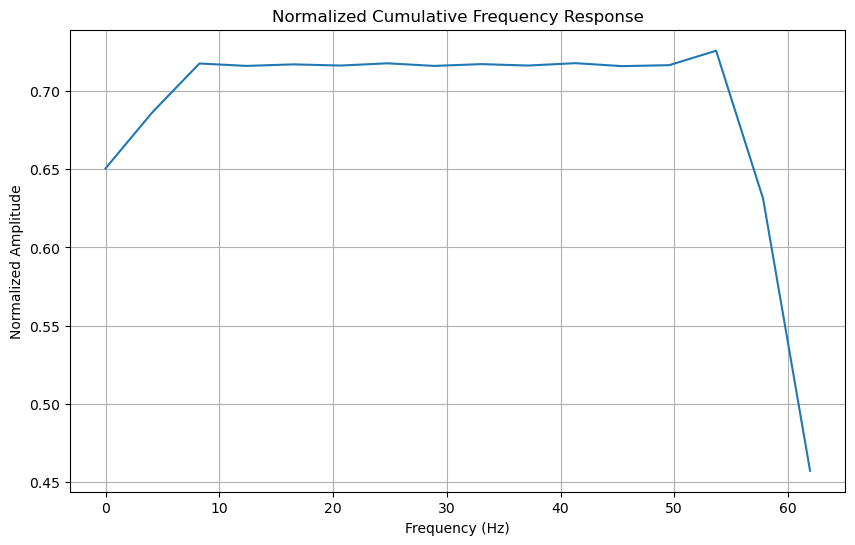

In [24]:
model = CLIPModel().to(Config.device)
eeg_Sinc = model.eeg_encoder.sinc_conv
freqs, avg_freq_response_rand = plot_frequency_response(eeg_Sinc, sample_rate=128)

In [25]:
# after Training

31
(16,)


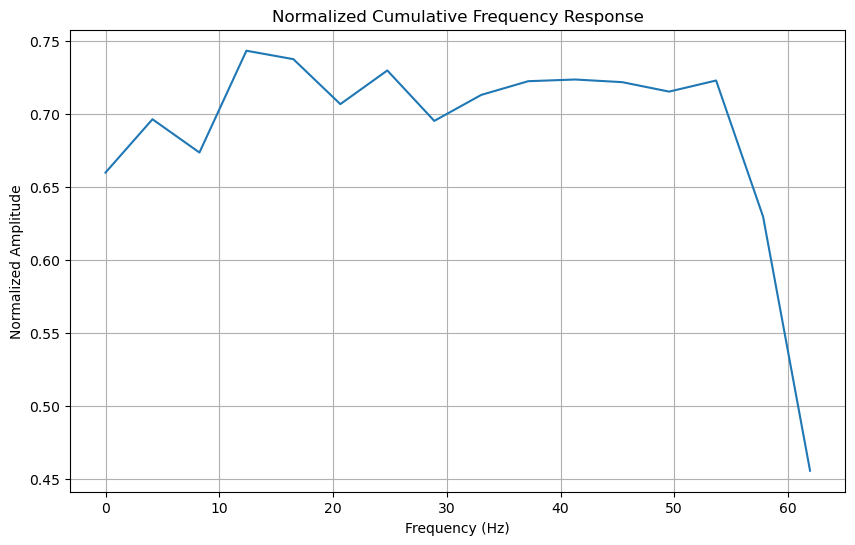

In [26]:
model = CLIPModel().to(Config.device)
# 加载模型参数
model.load_state_dict(torch.load("Cross_trails_trysomething_new_1019/S4/cross_trails_s4_best.pt"))

eeg_Sinc_1 = model.eeg_encoder.sinc_conv
freqs,avg_freq_response_learn = plot_frequency_response(eeg_Sinc_1, sample_rate=128)

In [27]:
# for all subject

Processing file: Cross_trails/S1/cross_trails_s1_best.pt
31
(16,)


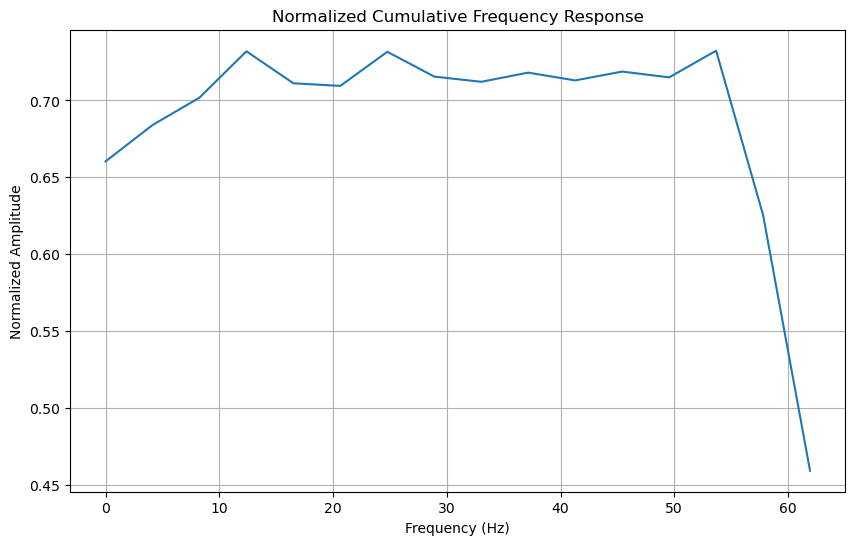

In [28]:
# Initialize an 18x16 array to store the results
results = np.zeros((18, 16))

# Iterate through folders S1 to S16
for i in range(1, 2):  # Adjust the range as needed (1 to 17 for S1 to S16)
    folder_name = f"S{i}"
    file_path = os.path.join("Cross_trails", folder_name, f"cross_trails_s{i}_best.pt")
    print(f"Processing file: {file_path}")
    
    # Check if the file exists
    if os.path.isfile(file_path):
        # Create the model and load parameters
        model = CLIPModel().to(Config.device)
        model.load_state_dict(torch.load(file_path))
        
        # Get the frequency response
        eeg_Sinc_1 = model.eeg_encoder.sinc_conv
        freqs, avg_freq_response_learn = plot_frequency_response(eeg_Sinc_1, sample_rate=128)
        
        # Save the results to the array, assuming you want to save the mean of avg_freq_response_learn
        # Here, it is assumed that avg_freq_response_learn is a one-dimensional array; adjust as needed
        results[i - 1, :len(avg_freq_response_learn)] = avg_freq_response_learn

# # Print the results
# print(results)

# # Save the results to a file (optional)
# np.save("avg_freq_response_learn_results.npy", results)

# # Save the results to a .mat file
# savemat("avg_freq_response_learn_results.mat", {"results": results})